In [1]:
import SimpleITK as sitk
import glob
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from feature_utils import *
import time

In [2]:
with open(os.getcwd()+'/data/df50.p','rb') as f:
    df50 = pd.read_pickle(f)

In [23]:
df50

,PID,gender,age,vessel,seg,ffr,ffr_80,n_frame,OS,distal,...,area4_stenosis_dist5,RI_MLA_ref,RI_MLA_prox5,RI_worst_ref,RI_worst_prox5,variance_lumen_worst,variance_lumen_PB40,variance_plaque_worst,variance_plaque_PB40,OS_MLA
0,F0002,1,59,1,1,0.83,0,2381,2152,91,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.094344,8.617363,2.883863,8.774294,825
1,F0003,2,73,1,2,0.91,0,3642,3097,551,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.111045,5.947169,0.040156,2.423447,2823
2,F0004,1,61,1,2,0.72,1,4060,3463,261,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.173158,0.886662,2.084295,6.673197,497
3,F0005,1,61,3,2,0.83,0,3970,3883,285,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.219113,2.347513,0.035961,1.283860,1623
4,F0007,1,60,1,2,0.85,0,2813,2610,465,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.015161,15.625794,3.051663,3.422363,1321
5,F0008,1,67,1,2,0.85,0,2801,2569,116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.618205,1.630930,0.932196,2.914963,1798
6,F0009,2,64,1,1,0.62,1,1521,1449,24,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.225412,5.323243,0.966667,4.951670,908
7,F0010,2,65,1,1,0.89,0,3497,3019,170,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.235086,3.371243,1.861028,5.198880,1461
8,F0011,1,63,1,1,0.82,0,3057,1899,46,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.449187,13.431475,1.239713,3.028877,930
9,F0012,2,61,3,2,0.88,0,2410,2343,30,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.401109,1.098317,3.117723,2.618343,1226


In [4]:
with open(os.getcwd()+'/data/df50.p','rb') as f:
    df50 = pd.read_pickle(f)

#constant variables
gap = 300       #combines lesions if number of frames between is less than
pbth = 0.4      #plaque burden threshold in lesion

## SMOOTHING
df50['pb'] = df50.apply(lambda x: list(plaqueburden(x.luA,x.plA)),axis=1)                                   #runtimewarning
df50['luAc'] = df50['luA'].apply(lambda x: np.convolve(x,np.ones((50,))/50,mode='same'))                    #smooth luA
df50['plAc'] = df50['plA'].apply(lambda x: np.convolve(x,np.ones((50,))/50,mode='same'))                    #smooth plA

## FEATURE EXTRACTION
df50['len_PB40'] = df50.apply(lambda x: lesion(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['len_PB70'] = df50.apply(lambda x: lesion(x.luAc,x.plAc,x.distal,x.OS,0.7,gap),axis=1)
df50['OS_PB40'] = df50.apply(lambda x: fromos_pb(x.luAc,x.plAc,x.distal,x.OS,0.4,gap),axis=1)
df50['OS_PB70'] = df50.apply(lambda x: fromos_pb(x.luAc,x.plAc,x.distal,x.OS,0.7,gap),axis=1)              
df50['OS_MLA'] = df50.apply(lambda x: fromos_mla(x.luAc,x.distal,x.OS),axis=1)                             
df50['MLA'] = df50.apply(lambda x: mla(x.luAc,x.distal,x.OS),axis=1)
df50['EEM_MLA'] = df50.apply(lambda x: eem_mla(x.luAc,x.plAc,x.distal,x.OS),axis=1)
df50['PB_MLA'] = df50.apply(lambda x: pb_mla(x.luAc,x.plAc,x.distal,x.OS),axis=1)
df50['No_PB40'] = df50.apply(lambda x: numberofpb(x.pb,pbth,x.distal,x.OS),axis=1)                           #runtimewarning
df50['No_PB70'] = df50.apply(lambda x: numberofpb(x.pb,0.7,x.distal,x.OS),axis=1)                           #runtimewarning

df50['No_lumen40_ROI'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,4.0,0),axis=1)
df50['No_lumen25_ROI'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,2.5,0),axis=1)
df50['No_lumen30_ROI'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,3.0,0),axis=1)
df50['Sum_plaque_ROI'] = df50.apply(lambda x: sum_plaque_roi(x.luAc,x.plAc,x.distal,x.OS,0),axis=1)
df50['Sum_EEM_ROI'] = df50.apply(lambda x: sum_eem_roi(x.luAc,x.plAc,x.distal,x.OS,0),axis=1)
df50['PB_ROI'] = df50.apply(lambda x: pb_roi(x.luAc,x.plAc,x.distal,x.OS,0),axis=1)
df50['mean_lumen_ROI'] = df50.apply(lambda x: mean_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,0),axis=1)
df50['mean_plaque_ROI'] = df50.apply(lambda x: mean_plaque_roi(x.luAc,x.plAc,x.distal,x.OS,0),axis=1)
df50['mean_EEM_ROI'] = df50.apply(lambda x: mean_eem_roi(x.luAc,x.plAc,x.distal,x.OS,0),axis=1)

df50['No_lumen40_PB40'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,4.0,pbth),axis=1)
df50['No_lumen25_PB40'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,2.5,pbth),axis=1)
df50['No_lumen30_PB40'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,3.0,pbth),axis=1)
df50['Sum_plaque_PB40'] = df50.apply(lambda x: sum_plaque_roi(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)
df50['Sum_EEM_PB40'] = df50.apply(lambda x: sum_eem_roi(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)
df50['PB_PB40'] = df50.apply(lambda x: pb_roi(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)                     
df50['mean_lumen_PB40'] = df50.apply(lambda x: mean_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)
df50['mean_plaque_PB40'] = df50.apply(lambda x: mean_plaque_roi(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)
df50['mean_EEM_PB40'] = df50.apply(lambda x: mean_eem_roi(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)

df50['No_lumen40_PB70'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,4.0,0.7),axis=1)
df50['No_lumen25_PB70'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,2.5,0.7),axis=1)
df50['No_lumen30_PB70'] = df50.apply(lambda x: no_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,3.0,0.7),axis=1)
df50['Sum_plaque_PB70'] = df50.apply(lambda x: sum_plaque_roi(x.luAc,x.plAc,x.distal,x.OS,0.7),axis=1)
df50['Sum_EEM_PB70'] = df50.apply(lambda x: sum_eem_roi(x.luAc,x.plAc,x.distal,x.OS,0.7),axis=1)
df50['PB_PB70'] = df50.apply(lambda x: pb_roi(x.luAc,x.plAc,x.distal,x.OS,0.7),axis=1)                     
df50['mean_lumen_PB70'] = df50.apply(lambda x: mean_lumen_roi(x.luAc,x.plAc,x.distal,x.OS,0.7),axis=1)
df50['mean_plaque_PB70'] = df50.apply(lambda x: mean_plaque_roi(x.luAc,x.plAc,x.distal,x.OS,0.7),axis=1)
df50['mean_EEM_PB70'] = df50.apply(lambda x: mean_eem_roi(x.luAc,x.plAc,x.distal,x.OS,0.7),axis=1)

df50['No_lumen40_worst'] = df50.apply(lambda x: no_lumen_worst(x.luAc,x.distal,x.OS,luth=4.0),axis=1)
df50['No_lumen25_worst'] = df50.apply(lambda x: no_lumen_worst(x.luAc,x.distal,x.OS,luth=2.5),axis=1)
df50['Sum_plaque_worst'] = df50.apply(lambda x: sum_plaque_worst(x.luAc,x.plAc,x.distal,x.OS),axis=1)
df50['Sum_EEM_worst'] = df50.apply(lambda x: sum_eem_worst(x.luAc,x.plAc,x.distal,x.OS),axis=1)
df50['PB_worst'] = df50.apply(lambda x: pb_worst(x.luAc,x.plAc,x.distal,x.OS),axis=1)
df50['mean_lumen_worst'] = df50.apply(lambda x: mean_lumen_worst(x.luAc,x.distal,x.OS),axis=1)
df50['mean_plaque_worst'] = df50.apply(lambda x: mean_plaque_worst(x.luAc,x.plAc,x.distal,x.OS),axis=1)
df50['mean_EEM_worst'] = df50.apply(lambda x: mean_eem_worst(x.luAc,x.plAc,x.distal,x.OS),axis=1)

df50['No_lumen40_prox'] = df50.apply(lambda x: no_lumen_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,4.0,gap),axis=1)   #all zeroes
df50['No_lumen25_prox'] = df50.apply(lambda x: no_lumen_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,2.5,gap),axis=1)   #all zeroes
df50['No_lumen30_prox'] = df50.apply(lambda x: no_lumen_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,3.0,gap),axis=1)   #all zeroes
df50['Sum_plaque_prox'] = df50.apply(lambda x: sum_plaque_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['Sum_EEM_prox'] = df50.apply(lambda x: sum_eem_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['PB_prox'] = df50.apply(lambda x: pb_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_lumen_prox'] = df50.apply(lambda x: mean_lumen_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_plaque_prox'] = df50.apply(lambda x: mean_plaque_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_EEM_prox'] = df50.apply(lambda x: mean_eem_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['max_EEM_prox'] = df50.apply(lambda x: max_eem_prox(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)

df50['No_lumen40_distal'] = df50.apply(lambda x: no_lumen_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,4.0,gap),axis=1)
df50['No_lumen25_distal'] = df50.apply(lambda x: no_lumen_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,2.5,gap),axis=1)   #all zeroes
df50['No_lumen30_distal'] = df50.apply(lambda x: no_lumen_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,3.0,gap),axis=1)   #all zeroes
df50['Sum_plaque_distal'] = df50.apply(lambda x: sum_plaque_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['Sum_EEM_distal'] = df50.apply(lambda x: sum_eem_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['PB_distal'] = df50.apply(lambda x: pb_distal(x.luAc,x.plAc,x.distal,x.OS,0.4,gap),axis=1)
df50['mean_lumen_distal'] = df50.apply(lambda x: mean_lumen_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_plaque_distal'] = df50.apply(lambda x: mean_plaque_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_EEM_distal'] = df50.apply(lambda x: mean_eem_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['max_EEM_distal'] = df50.apply(lambda x: max_eem_distal(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)

df50['No_lumen40_prox5'] = df50.apply(lambda x: no_lumen40_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,4.0,gap),axis=1)   #all zeroes
df50['No_lumen25_prox5'] = df50.apply(lambda x: no_lumen40_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,2.5,gap),axis=1)   #all zeroes
df50['No_lumen30_prox5'] = df50.apply(lambda x: no_lumen40_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,3.0,gap),axis=1)   #all zeroes
df50['Sum_plaque_prox5'] = df50.apply(lambda x: sum_plaque_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['Sum_EEM_prox5'] = df50.apply(lambda x: sum_eem_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['PB_prox5'] = df50.apply(lambda x: pb_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_lumen_prox5'] = df50.apply(lambda x: mean_lumen_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_plaque_prox5'] = df50.apply(lambda x: mean_plaque_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_EEM_prox5'] = df50.apply(lambda x: mean_eem_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['max_EEM_prox5'] = df50.apply(lambda x: max_eem_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)

df50['No_lumen40_dist5'] = df50.apply(lambda x: no_lumen40_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,4.0,gap),axis=1)   #all zeroes
df50['No_lumen25_dist5'] = df50.apply(lambda x: no_lumen40_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,2.5,gap),axis=1)   #all zeroes
df50['No_lumen30_dist5'] = df50.apply(lambda x: no_lumen40_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,3.0,gap),axis=1)   #all zeroes
df50['Sum_plaque_dist5'] = df50.apply(lambda x: sum_plaque_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['Sum_EEM_dist5'] = df50.apply(lambda x: sum_eem_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['PB_dist5'] = df50.apply(lambda x: pb_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_lumen_dist5'] = df50.apply(lambda x: mean_lumen_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_plaque_dist5'] = df50.apply(lambda x: mean_plaque_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_EEM_dist5'] = df50.apply(lambda x: mean_eem_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['max_EEM_dist5'] = df50.apply(lambda x: max_eem_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)

df50['mean_lumen_aver'] = df50.apply(lambda x: mean_lumen_aver(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['mean_EEM_aver'] = df50.apply(lambda x: mean_eem_aver(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area1_stenosis_aver'] = df50.apply(lambda x: area1_stenosis_aver(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area1_stenosis_prox5'] = df50.apply(lambda x: area1_stenosis_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area1_stenosis_dist5'] = df50.apply(lambda x: area1_stenosis_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area2_stenosis_aver'] = df50.apply(lambda x: area2_stenosis_aver(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area2_stenosis_prox5'] = df50.apply(lambda x: area2_stenosis_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area2_stenosis_dist5'] = df50.apply(lambda x: area2_stenosis_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area3_stenosis_aver'] = df50.apply(lambda x: area3_stenosis_aver(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area3_stenosis_prox5'] = df50.apply(lambda x: area3_stenosis_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area3_stenosis_dist5'] = df50.apply(lambda x: area3_stenosis_dist5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area4_stenosis_aver'] = df50.apply(lambda x: area4_stenosis_aver(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area4_stenosis_prox5'] = df50.apply(lambda x: area4_stenosis_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['area4_stenosis_dist5'] = df50.apply(lambda x: area4_stenosis_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)

# 102-112 Not completed

df50['RI_MLA_ref'] = df50.apply(lambda x: ri_mla_ref(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['RI_MLA_prox5'] = df50.apply(lambda x: ri_mla_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['RI_worst_ref'] = df50.apply(lambda x: ri_worst_ref(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['RI_worst_prox5'] = df50.apply(lambda x: ri_worst_prox5(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)
df50['variance_lumen_worst'] = df50.apply(lambda x: variance_lumen_worst(x.luAc,x.distal,x.OS),axis=1)
df50['variance_lumen_PB40'] = df50.apply(lambda x: variance_lumen_pb40(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)
df50['variance_plaque_worst'] = df50.apply(lambda x: variance_plaque_worst(x.luAc,x.plAc,x.distal,x.OS),axis=1)
df50['variance_plaque_PB40'] = df50.apply(lambda x: variance_plaque_pb40(x.luAc,x.plAc,x.distal,x.OS,pbth),axis=1)

# 121-122 Not completed



/Users/paulnguyen/Desktop/Regis/Practicum2/bloodpressure_ffr/feature_utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  return y/(x + y)
/Users/paulnguyen/Desktop/Regis/Practicum2/bloodpressure_ffr/feature_utils.py:252: RuntimeWarning: invalid value encountered in greater
  index = np.where(roi > pbth)[0]


In [13]:
df50.describe()

,gender,age,vessel,seg,ffr,ffr_80,n_frame,OS,distal,OS_PB40,...,area4_stenosis_dist5,RI_MLA_ref,RI_MLA_prox5,RI_worst_ref,RI_worst_prox5,variance_lumen_worst,variance_lumen_PB40,variance_plaque_worst,variance_plaque_PB40,OS_MLA
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,1.219512,64.829268,1.634146,1.560976,0.807317,0.414634,3433.390244,3113.560976,454.780488,166.609756,...,0.015063,0.040205,0.020103,0.043870,0.021935,1.443710,6.328712,1.621892,7.650151,1991.439024
std,0.419058,7.848256,0.993884,0.549945,0.103127,0.498779,1015.833399,1066.835720,428.444250,277.378611,...,0.096452,0.257438,0.128719,0.280908,0.140454,3.572996,4.503015,1.818431,13.504875,1152.386677
min,1.000000,42.000000,1.000000,1.000000,0.450000,0.000000,1282.000000,909.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.029505,0.886662,0.027832,0.678668,303.000000
25%,1.000000,60.000000,1.000000,1.000000,0.750000,0.000000,2638.000000,2343.000000,114.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.223603,3.371243,0.430218,3.028877,1234.000000
50%,1.000000,65.000000,1.000000,2.000000,0.830000,0.000000,3497.000000,3170.000000,304.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.473602,5.021951,0.966667,5.417006,1798.000000
75%,1.000000,70.000000,3.000000,2.000000,0.880000,1.000000,4051.000000,3883.000000,603.000000,289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.064431,7.369121,2.116425,7.696879,2600.000000
max,2.000000,83.000000,4.000000,3.000000,0.970000,1.000000,5997.000000,5996.000000,1438.000000,835.000000,...,0.617597,1.648406,0.824203,1.798687,0.899343,22.357371,19.688111,7.856787,89.793584,5111.000000


In [15]:
dfcorr = df50.corr()
dfcorr

,gender,age,vessel,seg,ffr,ffr_80,n_frame,OS,distal,OS_PB40,...,area4_stenosis_dist5,RI_MLA_ref,RI_MLA_prox5,RI_worst_ref,RI_worst_prox5,variance_lumen_worst,variance_lumen_PB40,variance_plaque_worst,variance_plaque_PB40,OS_MLA
gender,1.000000,0.095295,0.077593,-0.222250,0.048678,-0.087518,-0.037087,-0.009174,0.241721,0.015166,...,-0.083853,-0.083853,-0.083853,-0.083853,-0.083853,-0.086371,-0.082925,0.293255,0.289103,-0.001758
age,0.095295,1.000000,0.325114,-0.145230,0.017644,0.133492,0.031153,-0.000926,0.054412,-0.295366,...,-0.180087,-0.180087,-0.180087,-0.180087,-0.180087,0.353718,0.412193,-0.067920,-0.208506,-0.014805
vessel,0.077593,0.325114,1.000000,0.156182,0.312148,-0.291515,-0.091944,0.019862,0.043076,-0.128396,...,0.058926,0.058926,0.058926,0.058926,0.058926,0.067158,0.192706,-0.043486,-0.167806,0.041769
seg,-0.222250,-0.145230,0.156182,1.000000,0.040425,0.042236,0.362704,0.470389,-0.164030,0.169620,...,-0.163289,-0.163289,-0.163289,-0.163289,-0.163289,-0.180807,-0.180762,0.016894,0.095323,0.481536
ffr,0.048678,0.017644,0.312148,0.040425,1.000000,-0.784638,-0.010738,0.019849,0.034812,0.250783,...,0.205957,0.205957,0.205957,0.205957,0.205957,0.114928,0.099914,0.059921,0.003818,0.098793
ffr_80,-0.087518,0.133492,-0.291515,0.042236,-0.784638,1.000000,0.118930,0.092859,0.028630,-0.147698,...,-0.133073,-0.133073,-0.133073,-0.133073,-0.133073,-0.189159,-0.080041,-0.163339,-0.046475,0.037385
n_frame,-0.037087,0.031153,-0.091944,0.362704,-0.010738,0.118930,1.000000,0.962996,0.263984,0.046312,...,-0.128492,-0.128492,-0.128492,-0.128492,-0.128492,-0.111975,-0.132118,0.116067,0.315854,0.795000
OS,-0.009174,-0.000926,0.019862,0.470389,0.019849,0.092859,0.962996,1.000000,0.286764,0.080816,...,-0.106769,-0.106769,-0.106769,-0.106769,-0.106769,-0.126810,-0.203711,0.160451,0.303651,0.832972
distal,0.241721,0.054412,0.043076,-0.164030,0.034812,0.028630,0.263984,0.286764,1.000000,0.056118,...,0.169335,0.169335,0.169335,0.169335,0.169335,0.043994,0.018130,0.249778,0.259008,0.397556
OS_PB40,0.015166,-0.295366,-0.128396,0.169620,0.250783,-0.147698,0.046312,0.080816,0.056118,1.000000,...,0.314173,0.314173,0.314173,0.314173,0.314173,-0.055256,0.171278,0.123157,0.298070,0.275761


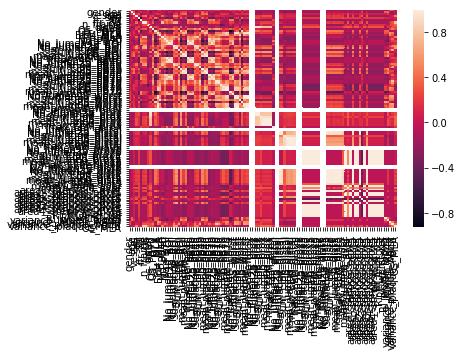

In [22]:
import seaborn as sns
sns.heatmap(dfcorr, 
        xticklabels=dfcorr.columns,
        yticklabels=dfcorr.columns)
plt.savefig('dfcorr.pdf')


In [5]:
df50['OS_MLA'] = df50.apply(lambda x: fromos_mla(x.luAc,x.distal,x.OS),axis=1) 

In [6]:
df50['OS_MLA']

0      825
1     2823
2      497
3     1623
4     1321
5     1798
6      908
7     1461
8      930
9     1226
10    2321
11    1047
12    1977
13    1716
14     642
15    5111
16    1234
17     378
18     303
19    2253
20    2419
21    5037
22    1411
23    1422
24    2817
25    2623
26    3956
27    1291
28    3184
29    3851
30    1813
31    2351
33    2389
34    1283
35    2536
36    2600
37    1983
38    3255
39    1568
40     617
41    2849
Name: OS_MLA, dtype: int64

In [7]:
# example values for testing
i=15
lu = df50.loc[i].lu
pl = df50.loc[i].pl
luA = df50.loc[i].luA
plA = df50.loc[i].plA
luAc = df50.loc[i].luAc
plAc = df50.loc[i].plAc
distal = df50.loc[i].distal
os = df50.loc[i].OS
pb = df50.loc[i].pb

In [8]:
fromos_mla(luAc,distal,os)

5111

In [10]:
indexmla = np.argmin(luAc[distal:os])
os - indexmla

5111

In [18]:
if(lesion(luAc,plAc,distal,os,pbth,gap)[-1][-1] < (os - 300)):
    indexprox = lesion(luAc,plAc,distal,os,pbth,gap)[-1][-1]
    prox5minindex = indexprox + np.argmin(luAc[indexprox:os])   #index of min lumen in prox ref
    if(prox5minindex > indexprox + 150 and prox5minindex < os - 150):
        prox5start = prox5minindex - 150
        prox5end = prox5minindex + 150
        lumenarea = np.where(luAc[prox5start:prox5end]<6)[0]
        print(len(lumenarea)) 
    else:
        print(0)    #if prox5 minimum lumen area is too close to lesion prox or os return 0
else:
    print(0)   ##if prox_ref is not greater than 300 frame return 0

223


In [54]:
print(prox5minindex > indexprox + 150, prox5minindex < os - 150)

True True


In [14]:
test = np.array([0,1,2,3])
test2 = np.array([True, False, True, False])
list(test[test2])

[0, 2]

In [26]:
835 + 965

1800

In [27]:
os

1800

In [12]:
test = []
len(test)

0

In [4]:
def windowed_mean(y,w):
    """
    window size = w
    step size = w/2
    """
    ymm=[]
    for j in range(len(y))[0:len(y):int(w/2)]:
        if len(y[j:j+w])==w:
            ymm.append(y[j:j+w].mean())
    return ymm
    
df50['luA_wm10'] = df50['luA'].apply(lambda x: windowed_mean(x,10)) # windowed mean lumen area with window=10
df50['luAt_wm10'] = df50['luAt'].apply(lambda x: windowed_mean(x,10)) # windowed mean lumen area in ROI with window=10
df50['mlat'] = df50['luAt'].apply(lambda x: min(x)) # minimum lumen area in ROI
df50['mlat_wm10'] = df50['luAt_wm10'].apply(lambda x: min(x)) #MLA (minimum lumen area) from windowed mean in ROI
z = df50['luA'].apply(lambda x: np.arange(len(x))) # a dummy variable for frame for plot
z_wm10 = df50['luA'].apply(lambda x: windowed_mean(np.arange(len(x)),10)) # a dummy variable for the windowed frame for plot
z_mlat = df50['distal']+df50['luAt'].apply(lambda x: np.argmin(x)) # z for MLA from ROI
z_mlat_wm10 = df50['distal']+df50['luAt_wm10'].apply(lambda x: 5+5*np.argmin(x)) # z for MLA from ROI when we take windowed mean for lumen area

In [5]:
len(z[1]), len(z_wm10[1]),len(df50['lu'][1])

(3642, 727, 3642)

In [6]:
def vis(i, th, show=True):
    """
    i: index
    th: plaqueburden threshold
    """
    pb = plaqueburden(df50.loc[i].luA, df50.loc[i].plA)
    lesionindex = lesion(df50.loc[i].luA, df50.loc[i].plA,th,300)
    plt.figure(figsize=(12,5));
    plt.plot(pb)
    ymax = max(pb)
    plt.ylim(0,ymax)
    ki = df50['distal'].loc[i]
    kf = df50['OS'].loc[i]
    plt.axvline(kf, color='lime', label='OS')
    plt.axvline(ki, color='magenta',label='distal')
    plt.axhline(th, color='red',label=th)
    
    for l in range(0,len(lesionindex)):
        start = lesionindex[l][0]
        end = lesionindex[l][1]
        plt.axvspan(start, end, facecolor='r', alpha=0.2)
        
    plt.legend(loc="right",bbox_to_anchor=(1.3, 0.5));
    if show:
        plt.show()
    else:
        return plt 

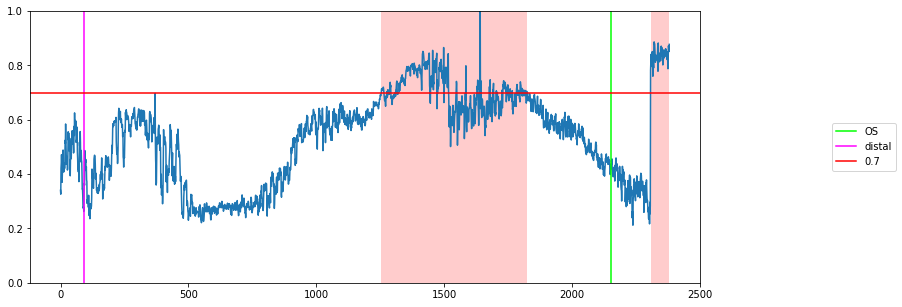

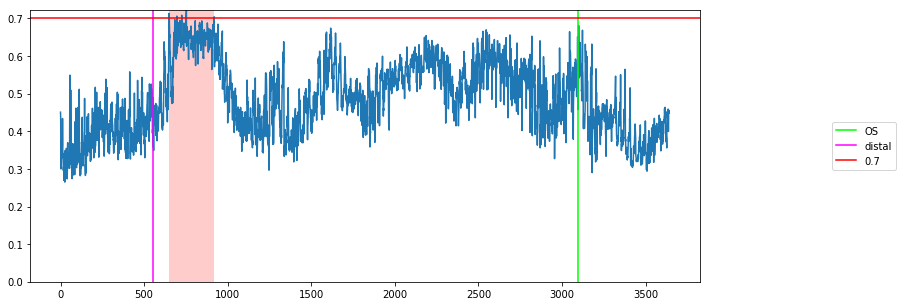

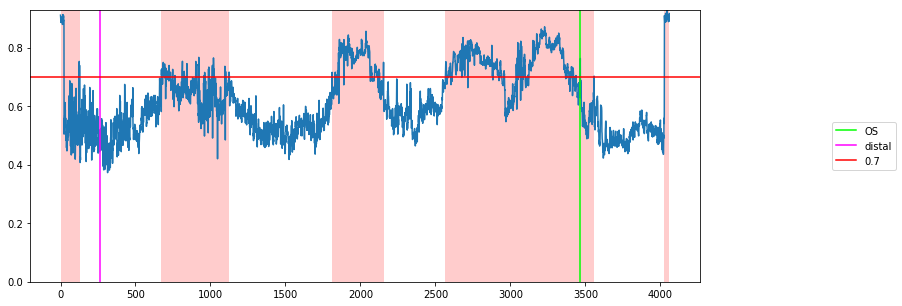

/Users/paulnguyen/Desktop/Regis/Practicum2/bloodpressure_ffr/feature_utils.py:92: RuntimeWarning: invalid value encountered in true_divide
  return y/(x + y)
/Users/paulnguyen/Desktop/Regis/Practicum2/bloodpressure_ffr/feature_utils.py:102: RuntimeWarning: invalid value encountered in greater
  index = np.where(plaqueburden(lu,pl) > th)[0]


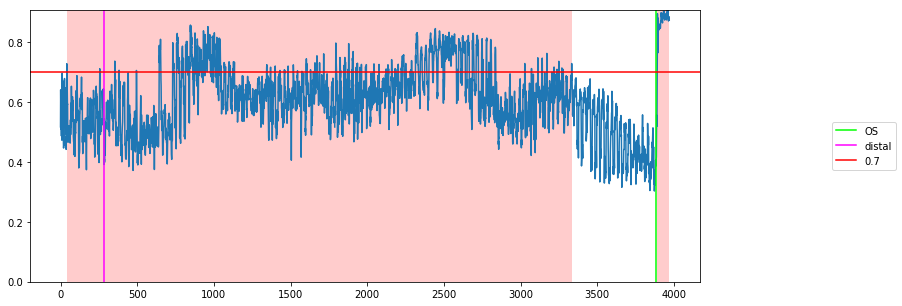

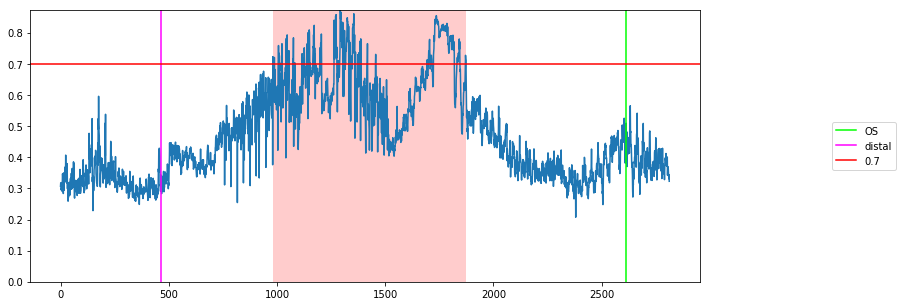

In [7]:
#pb = plaqueburden(df50.loc[0].luA, df50.loc[0].plA)
#lesion = lesion(df50.loc[0].luA, df50.loc[0].plA,0.4,300)
for i in range(0,5):
    vis(i,0.7)

In [8]:
type(df50.loc[0].luA)


numpy.ndarray

In [9]:
len(lesion(lu,pl,0.4,300))

NameError: name 'lu' is not defined

In [3]:
with open(os.getcwd()+'/data/df50.p','rb') as f:
    df50 = pd.read_pickle(f)

#constant variables
gap = 300       #combines lesions if number of frames between is less than
pbth = 0.4      #plaque burden threshold in lesion

## SMOOTHING
df50['pb'] = df50.apply(lambda x: list(plaqueburden(x.luA,x.plA)),axis=1)                                   #runtimewarning
df50['luAc'] = df50['luA'].apply(lambda x: np.convolve(x,np.ones((50,))/50,mode='same'))                    #smooth luA
df50['plAc'] = df50['plA'].apply(lambda x: np.convolve(x,np.ones((50,))/50,mode='same'))  

/Users/paulnguyen/Desktop/Regis/Practicum2/bloodpressure_ffr/feature_utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  return y/(x + y)


In [5]:
df50['long_eccentricity_worst'] = df50.apply(lambda x: long_eccentricity_worst(x.luAc,x.plAc,x.distal,x.OS),axis=1)

In [8]:
df50['long_eccentricity_PB40'] = df50.apply(lambda x: long_eccentricity_pb40(x.luAc,x.plAc,x.distal,x.OS,pbth,gap),axis=1)

In [9]:
df50.head()

,PID,gender,age,vessel,seg,ffr,ffr_80,n_frame,OS,distal,...,pl,luA,plA,luAt,plAt,pb,luAc,plAc,long_eccentricity_worst,long_eccentricity_PB40
0,F0002,1,59,1,1,0.83,0,2381,2152,91,...,"[2329, 2337, 3093, 3639, 4299, 4032, 2820, 309...","[5.65995771008, 6.05341060381, 5.30910799593, ...","[2.91831780092, 2.92834207847, 3.87563630668, ...","[7.87908215209, 7.30519226251, 9.25616728013, ...","[2.80303860913, 4.09491737802, 5.35421724489, ...","[0.34019865615, 0.326032366071, 0.421964529332...","[2.84120604589, 2.95921685332, 3.07770381392, ...","[2.29510846582, 2.39753152165, 2.49531834913, ...",0.072780,0.356138
1,F0003,2,73,1,2,0.91,0,3642,3097,551,...,"[3038, 2923, 2509, 1992, 2036, 2141, 2291, 254...","[5.21015625, 5.29734375, 5.82046875, 6.5390625...","[4.2721875, 4.11046875, 3.52828125, 2.80125, 2...","[5.7515625, 6.03984375, 6.18328125, 4.9078125,...","[3.915, 3.6590625, 3.4509375, 4.71234375, 3.93...","[0.450541302091, 0.43692077728, 0.377406738869...","[3.197390625, 3.332615625, 3.470146875, 3.5962...","[1.63085625, 1.68733125, 1.7368875, 1.80430312...",0.058916,0.892380
2,F0004,1,61,1,2,0.72,1,4060,3463,261,...,"[7839, 7463, 6465, 6451, 7254, 7010, 7309, 676...","[1.08140625, 1.125, 1.0603125, 1.17, 1.1685937...","[11.02359375, 10.49484375, 9.09140625, 9.07171...","[4.4465625, 4.1484375, 4.07671875, 4.460625, 4...","[3.56625, 3.99515625, 4.381875, 3.6703125, 4.2...","[0.910664498141, 0.903182863367, 0.89555340074...","[0.639928125, 0.71656875, 0.790340625, 0.86639...","[4.97795625, 5.06323125, 5.156775, 5.2468875, ...",0.046846,0.073704
3,F0005,1,61,3,2,0.83,0,3970,3883,285,...,"[3025, 4145, 3621, 3865, 3048, 3062, 2879, 345...","[3.97828125, 3.27515625, 3.6225, 3.36234375, 4...","[4.25390625, 5.82890625, 5.09203125, 5.4351562...","[6.80484375, 6.53203125, 6.654375, 6.52640625,...","[4.47609375, 4.52671875, 4.40578125, 4.4564062...","[0.516740690126, 0.640253320976, 0.58431499112...","[1.92256875, 1.984471875, 2.0377125, 2.1084468...","[2.33881875, 2.439225, 2.55133125, 2.64673125,...",0.041690,0.371873
4,F0007,1,60,1,2,0.85,0,2813,2610,465,...,"[1852, 1927, 2007, 1891, 1963, 1900, 1917, 209...","[5.88234375, 5.8078125, 6.0665625, 6.3365625, ...","[2.604375, 2.70984375, 2.82234375, 2.65921875,...","[6.77671875, 6.93703125, 7.29984375, 7.3575, 7...","[3.34265625, 3.44390625, 2.88140625, 3.11625, ...","[0.306876553438, 0.318144295856, 0.31751305173...","[2.972334375, 3.08221875, 3.18661875, 3.289528...","[1.406953125, 1.459546875, 1.5174, 1.577615625...",0.069930,0.153380
